In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/purzelrakete/src/github.com/feldberlin/wavenet


In [20]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from wavenet import model, train, sample, audio, datasets, utils, viz

# Train on 440 hz Sines

A very simple dataset, should be able to crush this. Sines all at 440 hz and unit amplitude, but different phases. Some ways of reducing the size of the problems:

- 4 cycles of sin should do, no need for a full second of audio. 160 samples
- Mu compress to 5 bits
- Fast generate only 160 samples
- Mono

We will try to train in around 10 minutes. 

    _REVIEW_
    
    At batches of 16 running at 2.35 it/s, we have 30*60=1800 seconds so 765 steps to complete over batches of 16 1s audios. This is around 200 minutes of audio to iterate over, so 20 epochs of 10 minutes each seems reasonable. That's around 40 steps per epoch, so 40*16=640 examples.
    
    ...
    

In [21]:
dry = True 
if dry:
    os.environ['WANDB_MODE'] = 'dryrun'

In [30]:
p = model.HParams(n_audio_chans=1, compress=False, sample_length=160, n_chans=64)
ds, ds_test = datasets.Sines(640, p, hz=440, amp=1.0, phase=0), datasets.Sines(640, p, hz=440, amp=1.0, phase=0)
X, Y = datasets.to_tensor(ds, 20)

In [31]:
m = model.Wavenet(p)
tp = train.HParams(max_epochs=15, batch_size=16, num_workers=1, learning_rate=0.005, mixed_precision=False)
t = train.Trainer(m, ds, ds_test, tp, None)
p.receptive_field_size()

3072

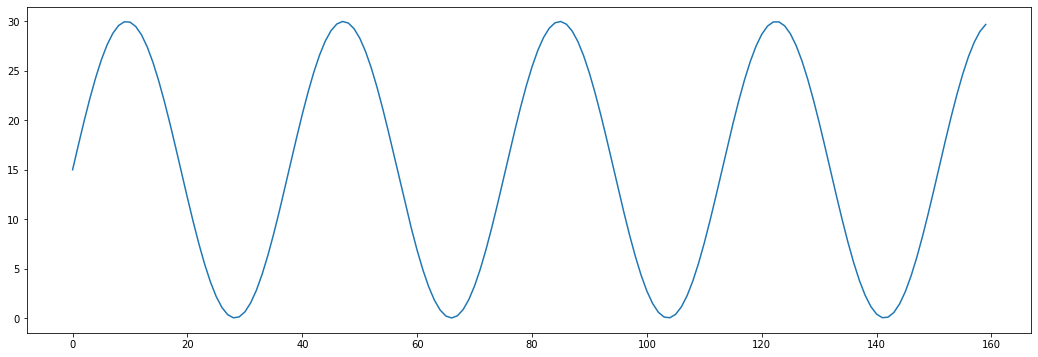

In [47]:
def sines():
    x = np.arange(0, 160)
    y = 15 * np.sin(x / 6.) + 15
    plt.figure(figsize=(18, 6))
    plt.plot(x, y)

sines()

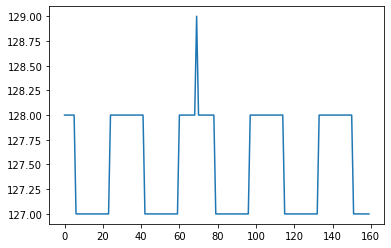

In [49]:
plt.plot(Y[1, 0])

(1, 160)

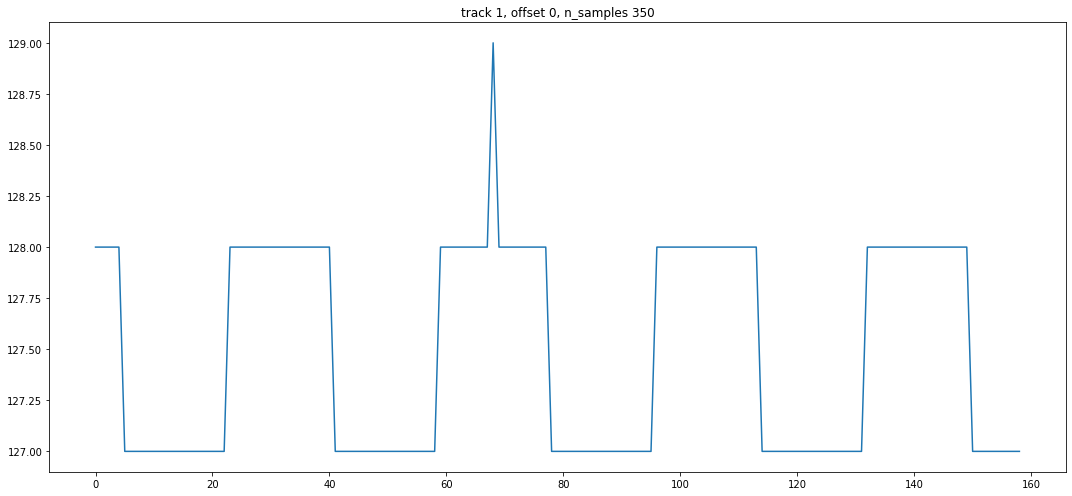

In [33]:
track_i = viz.plot_track(Y)
track = X[track_i].numpy()
track.shape

In [26]:
expanded = audio.mu_expand(track.repeat(500, axis=1), p)

In [27]:
expanded.shape

(1, 80000)

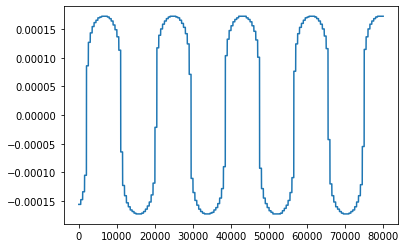

In [28]:
plt.plot(range(80000), expanded[0])

In [ ]:
ipd.Audio(expanded, rate=p.sampling_rate)

In [9]:
t.train()

/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
wandb: Offline run mode, not syncing to the cloud.
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` to enable cloud syncing.
wandb: WARNING Symlinked 2 files into the W&B run directory, call wandb.save again to sync new files.
  0%|          | 0/40 [00:00<?, ?it/s]/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
15:39 loss 0.29981 lr 8.993707e-08: 100%|██████████| 40/40 [00:18<00

In [10]:
def sample_simple(model, n_samples = 48):
    generated = X.new_zeros((n_samples,) + X.size()[1:])
    flat = generated.view(generated.size(0), -1)

    # sampling
    for t in range(flat.size(1)):
        x = (generated.float() - 0) / 1
        y, _ = model(x)
        logits = y.view(flat.size() + (-1,))[:, t]
        dist = torch.distributions.categorical.Categorical(logits = logits)
        flat[:, t] = dist.sample()
        
    return generated

1

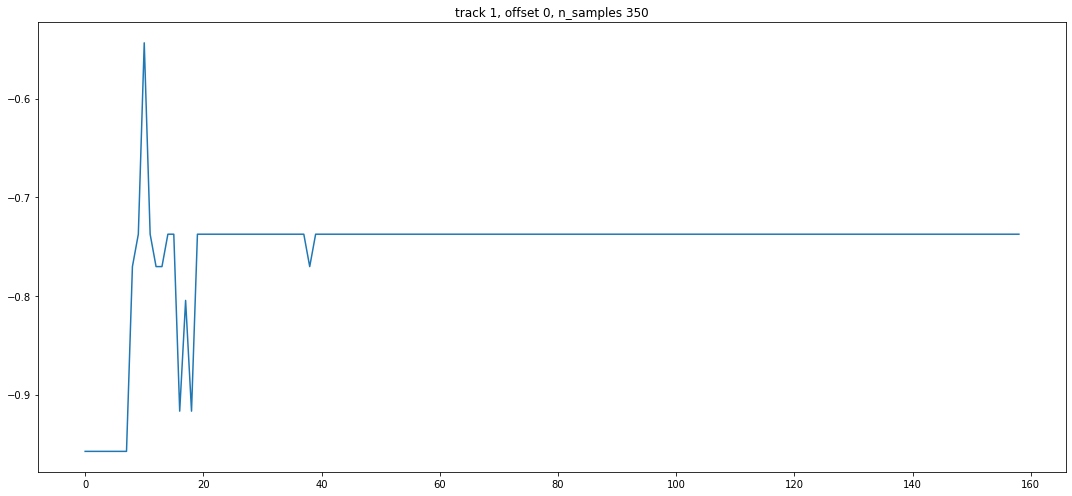

In [11]:
_, track = sample.sample(m, decoder=utils.decode_argmax, n_samples=p.sample_length, batch_size=8)
viz.plot_track(track)

/Users/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


3

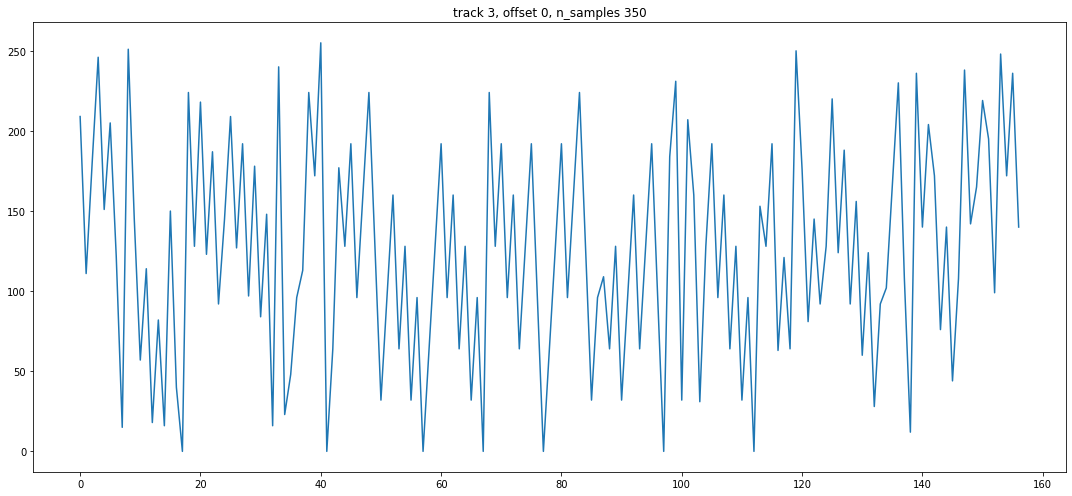

In [12]:
track = sample_simple(m)
viz.plot_track(track)

In [13]:
ipd.Audio(track[0], rate=p.sampling_rate)